In [2]:
#importing all required libraries and load the tensorflow notebook extension
%load_ext tensorboard

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import folium

from folium import plugins

import tensorflow as tf
import tensorflow.keras as keras
print(tf.__version__)

device = "gpu"

if device == "tpu":
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)
  # This is the TPU initialization code that has to be at the beginning.
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.experimental.TPUStrategy(resolver)
else:
  strategy = tf.distribute.MultiWorkerMirroredStrategy()

2.4.1
INFO:tensorflow:Using MirroredStrategy with devices ('/device:CPU:0',)
INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:CPU:0',), communication = CommunicationImplementation.AUTO


## **Data Loading and Preprocessing**

In [3]:
import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/temp.csv',index_col=0)
df.head()

key  ...  passenger_count
0   2012-01-13 11:28:00.00000062  ...                6
1    2014-06-30 11:26:37.0000001  ...                1
2    2012-04-08 13:42:13.0000001  ...                1
3  2009-08-18 11:18:00.000000117  ...                1
4  2013-04-30 08:00:00.000000137  ...                1

[5 rows x 8 columns]

In [4]:
df.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [5]:
#dropping null rows
df=df.dropna()

In [6]:
len(df)

99999

In [7]:
df.nunique()

key                  99999
fare_amount            919
pickup_datetime      99113
pickup_longitude     51851
pickup_latitude      58169
dropoff_longitude    54492
dropoff_latitude     61003
passenger_count          7
dtype: int64

In [8]:
df.describe()

fare_amount  pickup_longitude  ...  dropoff_latitude  passenger_count
count  99999.000000      99999.000000  ...      99999.000000     99999.000000
mean      11.384571        -72.505704  ...         39.880209         1.687527
std        9.776925         10.558887  ...         12.428476         1.311993
min      -45.000000        -84.483332  ...      -3114.324368         0.000000
25%        6.000000        -73.991945  ...         40.734256         1.000000
50%        8.500000        -73.981758  ...         40.753279         1.000000
75%       12.500000        -73.966915  ...         40.768133         2.000000
max      230.000000        415.367817  ...        409.633332         6.000000

[8 rows x 6 columns]

In [9]:
#dropping rows where the fare is above 200 considering it as outlier, however only one row is present
df = df.drop(df[df['fare_amount'] > 200].index)

In [10]:
df.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [11]:
#dropping unnecessary columns
df=df.drop(columns='key')
df.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [12]:
##Train test split ( Original DF )
np.random.seed(seed=2)
msk = np.random.rand(len(df)) < 0.85
data = df[msk]
evaldata = df[~msk]

print(len(data))
print(len(evaldata))

data.to_csv("train.csv", index=False, header=False)
evaldata.to_csv("eval.csv", index=False, header=False)

84948
15049


In [13]:
#function to retrieve the date, time, month, year, day details 
def Extract_datetime_features(df):
    df['pickup_datetime'] = df['pickup_datetime'].str.slice(0, 16)
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
    df['hour'] = df.pickup_datetime.dt.hour
    df['month'] = df.pickup_datetime.dt.month
    df["year"] = df.pickup_datetime.dt.year
    df["day"] = df.pickup_datetime.dt.weekday
    return df


#function to calculate the trip distance
from math import sin, cos, sqrt, atan2, radians
def Calculate_distance(lat1,lon1,lat2,lon2):
  # approximate radius of earth in km
  R = 6373.0
  dlon=lon2-lon1
  dlat=lat2-lat1
  a=sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2 
  c = 2 * atan2(sqrt(a), sqrt(1 - a))
  d=R*c
  return d 


In [14]:
data = Extract_datetime_features(data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [15]:

distances_km=[]
for row in data.itertuples(index=False):
  distances_km.append(Calculate_distance(row.pickup_latitude, row.pickup_longitude, row.dropoff_latitude, row.dropoff_longitude))
data['trip_distance_km']=distances_km

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [16]:
data.head(2)

fare_amount           pickup_datetime  ...  day  trip_distance_km
0         14.9 2012-01-13 11:28:00+00:00  ...    4        164.644850
1          6.0 2014-06-30 11:26:00+00:00  ...    0         98.678193

[2 rows x 12 columns]

## Data Exploration

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


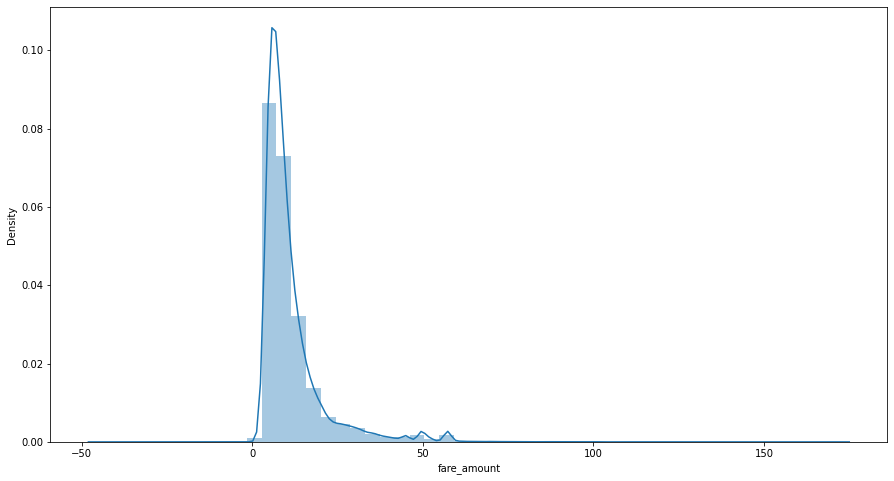

In [17]:
##Distribution of Fare
plt.figure(figsize=(15, 8))
sns.distplot(data['fare_amount'])

In [18]:
##Plot locations with heatmap intensity as per the FARE_AMOUNT
m = folium.Map()
sw = data[['pickup_latitude', 'pickup_longitude']].min().values.tolist()
ne = data[['pickup_latitude', 'pickup_longitude']].max().values.tolist()
m.add_child(plugins.HeatMap(zip(data['pickup_latitude'], data['pickup_longitude'], data['fare_amount']), radius = 10))
m.fit_bounds([sw, ne])
m

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

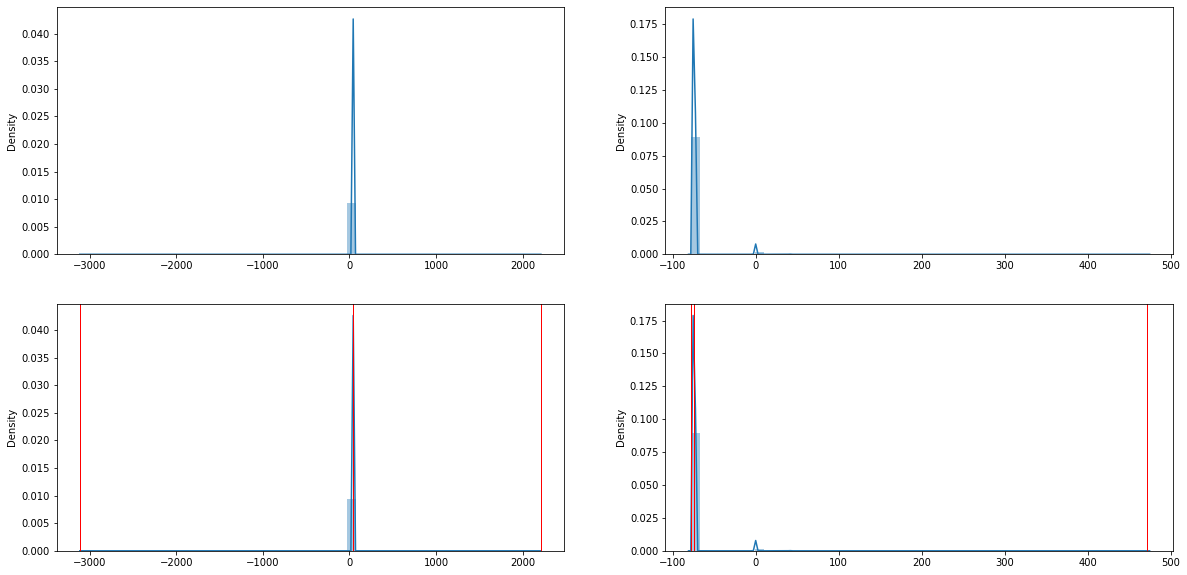

In [19]:
##Quantile Bucketization of latitude and longitude

bins_lat = pd.qcut(list(data['dropoff_latitude'].values) + list(data['pickup_latitude'].values), q=20, duplicates='drop', retbins=True)[1]
bins_lon = pd.qcut(list(data['dropoff_longitude'].values) + list(data['pickup_longitude'].values), q=20, duplicates='drop', retbins=True)[1]

#Plot all latitude values with bins
f, axes = plt.subplots(2, 2, figsize=(20, 10), sharex=False)
sns.distplot(list(data['dropoff_latitude'].values) + list(data['pickup_latitude'].values), ax=axes[0, 0])
sns.distplot(list(data['dropoff_longitude'].values) + list(data['pickup_longitude'].values), ax=axes[0, 1])

#Plot bins
sns.distplot(list(data['dropoff_latitude'].values) + list(data['pickup_latitude'].values), ax=axes[1, 0])
sns.distplot(list(data['dropoff_longitude'].values) + list(data['pickup_longitude'].values), ax=axes[1, 1])
for b_ in bins_lat:
  axes[1][0].axvline(b_, color='red', linewidth=1 )
for b_ in bins_lon:
  axes[1][1].axvline(b_, color='red', linewidth=1 )

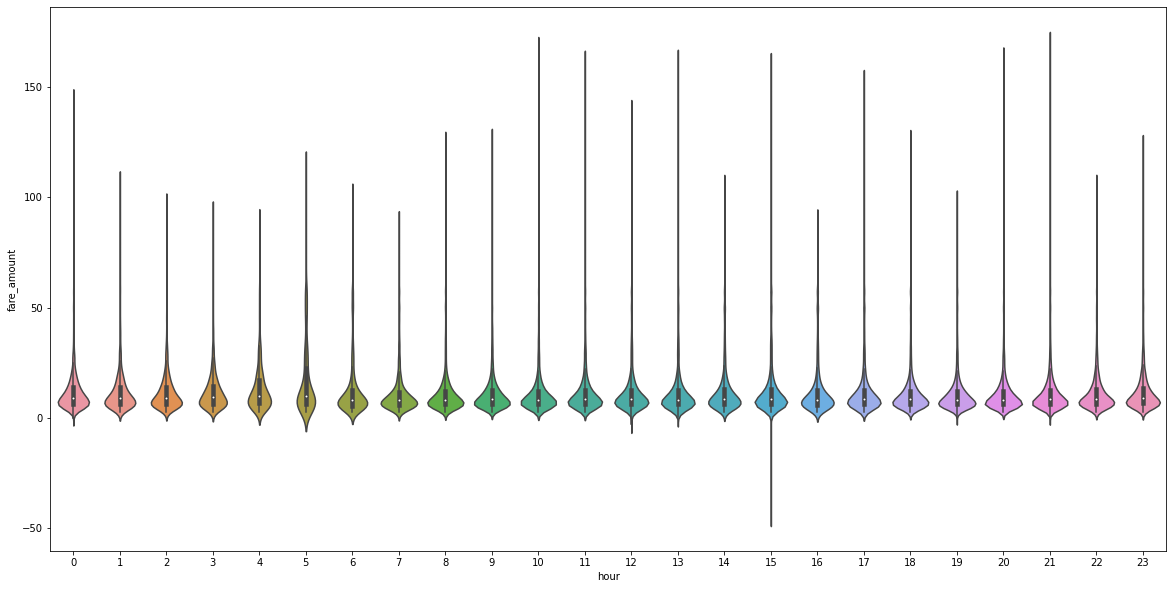

In [20]:
#plot for the start hour of the trip
plt.figure(figsize=(20, 10))
sns.violinplot(x=data['hour'].astype(int), y=data['fare_amount'])

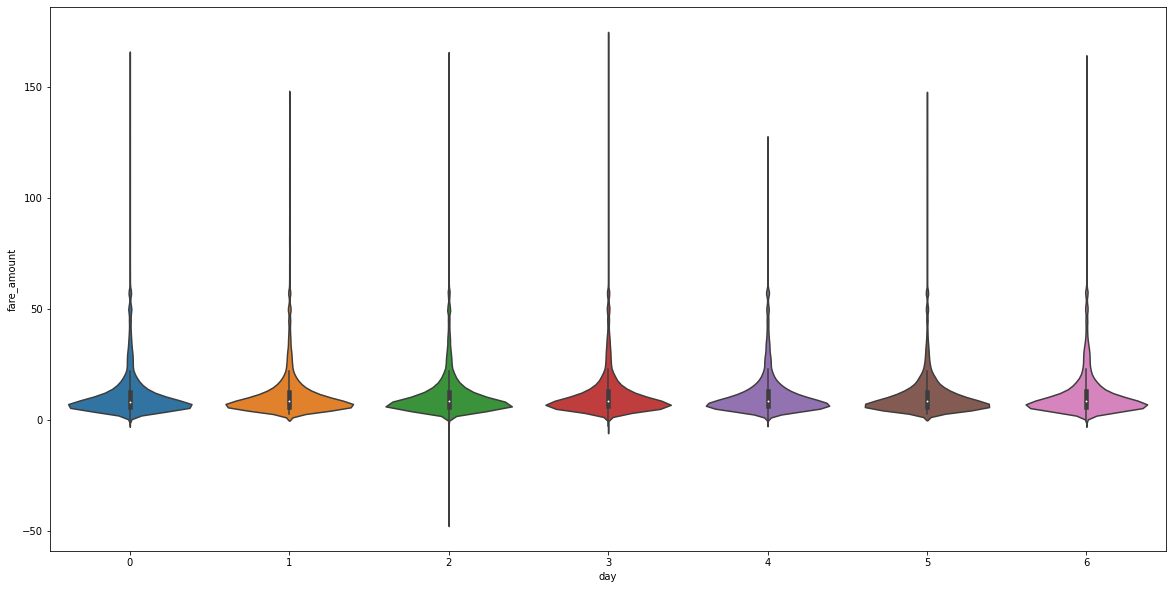

In [21]:
#plot for the start day of the trip
plt.figure(figsize=(20, 10))
sns.violinplot(x=data['day'].astype(int), y=data['fare_amount'])

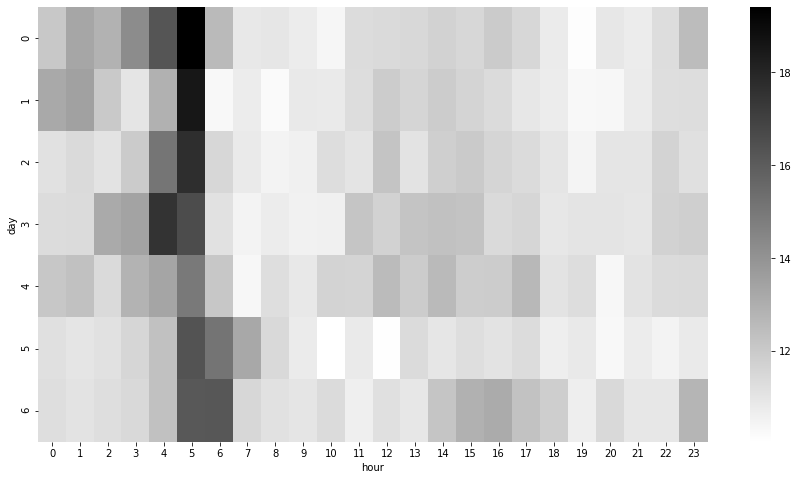

In [22]:
#Average trip fare( day & hour combined )
plt.figure(figsize=(15, 8))
cross = pd.crosstab(data['day'] , pd.to_numeric(data['hour']) , data['fare_amount'], aggfunc=np.average)
sns.heatmap(cross, annot=False, fmt='g', cmap='binary')

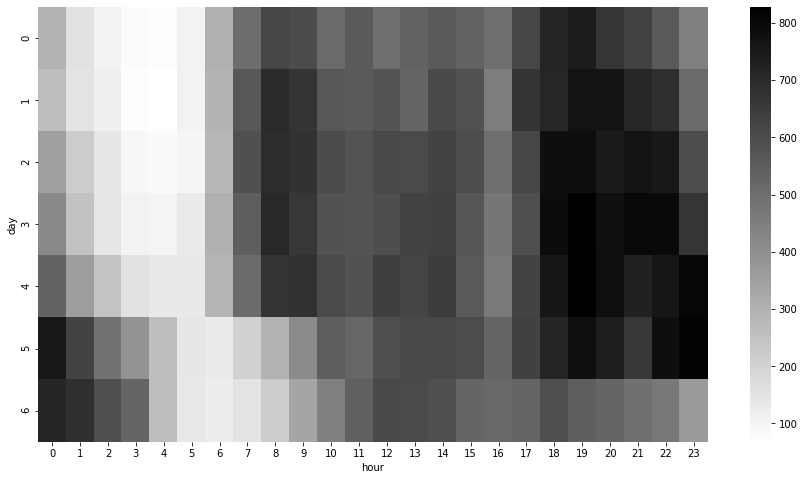

In [23]:
##Number of trips( day-hour wise )
plt.figure(figsize=(15, 8))
cross = pd.crosstab(data['day'] , pd.to_numeric(data['hour']) , data.index , aggfunc='count')
sns.heatmap(cross, annot=False, fmt='g', cmap='binary')

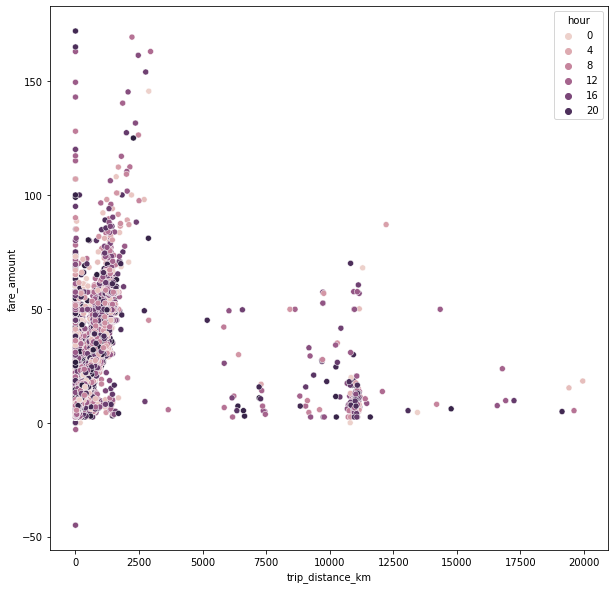

In [24]:
##Fare Vs distance plot( Colored by Trip Start Hour )
plt.figure(figsize=(10, 10))
sns.scatterplot(x=data['trip_distance_km'], y=data['fare_amount'], hue=data['hour'].astype(int))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


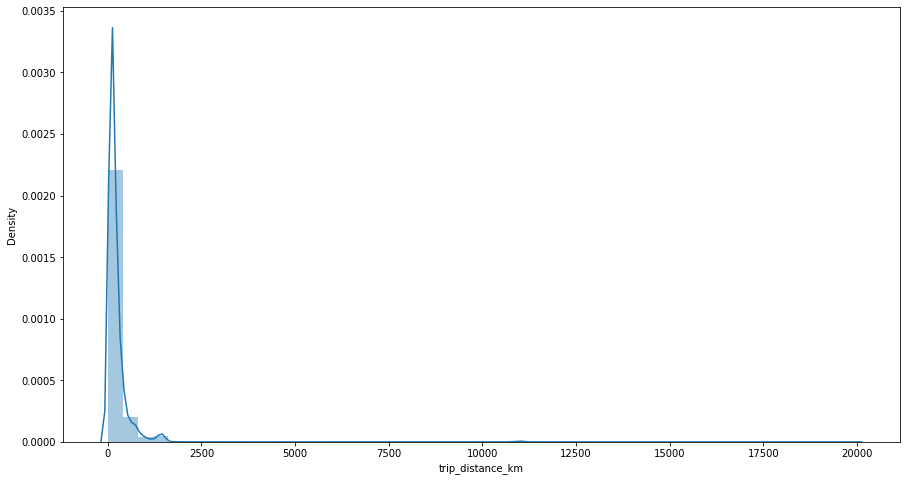

In [25]:
plt.figure(figsize=(15, 8))
sns.distplot(data['trip_distance_km'])

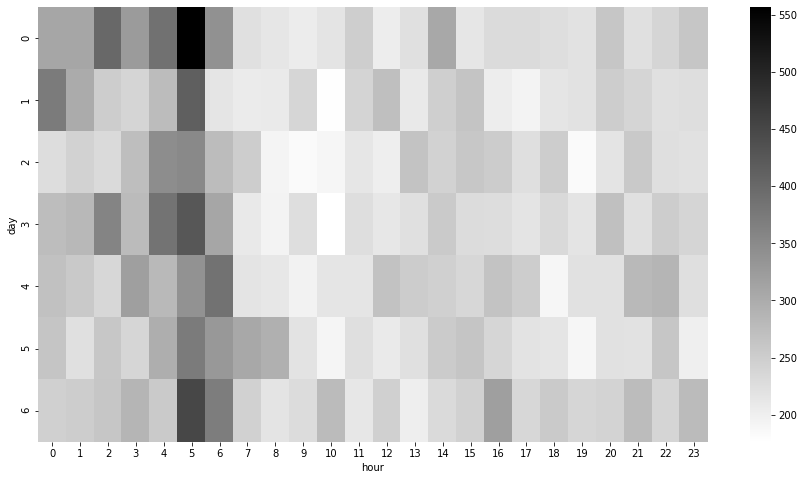

In [26]:
##Average trip distance( day-hour wise )
plt.figure(figsize=(15, 8))
cross = pd.crosstab(data['day'] , pd.to_numeric(data['hour']) , data['trip_distance_km'], aggfunc=np.average)
sns.heatmap(cross, annot=False, fmt='g', cmap='binary')

In [27]:
#splitting training and testing dataset 
np.random.seed(seed=2)
mask = np.random.rand(len(df)) < 0.85
traindata = df[mask]
evaldata = df[~mask]

print(len(traindata))
print(len(evaldata))

traindata.to_csv("train.csv", index=False, header=False)
evaldata.to_csv("eval.csv", index=False, header=False)

84948
15049


## Pipeline

In [28]:
###############################
##Feature engineering functions
def feature_engg_features(df):
  #Add new features
  #df['trip_distance_km'] = Calculate_distance(df['pickup_latitude'],df['pickup_longitude'],df['dropoff_latitude'],df['dropoff_longitude']) 
  df['trip_distance_km']=((df['pickup_latitude'] - df['dropoff_latitude'])**2 +  (df['pickup_longitude'] - df['dropoff_longitude'])**2)**0.5
  df['split_date_time'] = tf.strings.split(df['pickup_datetime'], ' ',name='split_date_time').to_tensor()
  df['date'] = tf.gather(df['split_date_time'] ,0 , axis=1)
  df['time'] = tf.gather(df['split_date_time'] ,1 , axis=1)
  df['split_date'] = tf.strings.split(df['date'], '-',name='split_date').to_tensor()
  df['split_time'] = tf.strings.split(df['time'], ':',name='split_time').to_tensor()
  df['month'] = tf.gather(df['split_date'] ,1 , axis=1)
  df['day'] = tf.gather(df['split_date'] ,2 , axis=1)
  df['hour'] = tf.gather(df['split_time'] ,0 , axis=1)
  return(df)

#To be called from TF
def feature_engg(df, label):
  #Add new features
  df = feature_engg_features(df)
  #df=Extract_datetime_features(df)
  return(df, label)  

In [29]:
traindata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84948 entries, 0 to 99998
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fare_amount        84948 non-null  float64
 1   pickup_datetime    84948 non-null  object 
 2   pickup_longitude   84948 non-null  float64
 3   pickup_latitude    84948 non-null  float64
 4   dropoff_longitude  84948 non-null  float64
 5   dropoff_latitude   84948 non-null  float64
 6   passenger_count    84948 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 5.2+ MB


In [30]:
###############################
###Data Input pipeline function
import datetime

# Determine CSV, label, and key columns
#Columns in training sheet -> Can have extra columns too
CSV_COLUMNS = traindata.columns
LABEL_COLUMN = 'fare_amount'

# Set default values for each CSV column( Including Y column )
DEFAULTS = [ [0.0], ['2014-06-30 11:26:37'],[0.0],[0.0],[0.0],[0.0],[0]]

def make_input_fn(filename, mode, vnum_epochs = None, batch_size = 512):
    def _input_fn(v_test=False):     
        # Create list of files that match pattern
        file_list = tf.io.gfile.glob(filename)

        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = vnum_epochs # indefinitely
        else:
            num_epochs = 1 # end-of-input after this        
        
        # Create dataset from file list
        dataset = tf.compat.v1.data.experimental.make_csv_dataset(file_list,
                                                   batch_size=batch_size,
                                                   column_names=CSV_COLUMNS,
                                                   column_defaults=DEFAULTS,
                                                   label_name=LABEL_COLUMN,
                                                   num_epochs = num_epochs,
                                                   num_parallel_reads=30)
        
        dataset = dataset.prefetch(buffer_size = batch_size)

        #Feature engineering
        dataset = dataset.map(feature_engg)

        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = vnum_epochs # indefinitely
            dataset = dataset.shuffle(buffer_size = batch_size)
        else:
            num_epochs = 1 # end-of-input after this

        dataset = dataset.repeat(num_epochs)       
        
        #Begins - Uncomment for testing only -----------------------------------------------------<
        if v_test == True:
          print(next(dataset.__iter__()))
          
        #End - Uncomment for testing only -----------------------------------------------------<
        return dataset
    return _input_fn

In [31]:
#Test dataset read + Feat Engg function's - output's CSV + Feature engg columns
eval_file = "train*.csv"
fn_d = make_input_fn(filename = eval_file,
                    mode = tf.estimator.ModeKeys.EVAL,
                    # vnum_epochs = 1,
                    batch_size = 10)

fn_d(v_test=True)


(OrderedDict([('pickup_datetime', <tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'2011-07-23 21:44:39 UTC', b'2013-10-25 14:02:31 UTC',
       b'2011-07-10 09:52:13 UTC', b'2010-12-30 22:55:00 UTC',
       b'2009-05-22 21:02:52 UTC', b'2011-04-11 16:42:02 UTC',
       b'2010-07-15 17:32:00 UTC', b'2015-01-02 02:07:38 UTC',
       b'2011-06-21 00:28:16 UTC', b'2012-04-19 22:53:32 UTC'],
      dtype=object)>), ('pickup_longitude', <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-73.98893 , -73.982445, -73.9775  , -73.977936, -73.99208 ,
       -73.99923 , -73.97814 , -73.957664, -73.984726, -74.01017 ],
      dtype=float32)>), ('pickup_latitude', <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([40.741932, 40.76775 , 40.7341  , 40.752216, 40.72532 , 40.712296,
       40.751938, 40.717922, 40.724182, 40.71211 ], dtype=float32)>), ('dropoff_longitude', <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-73.973335, -73.98065 , -74.0099  , -73.98573 , -74.002815,
       -

<DatasetV1Adapter shapes: (OrderedDict([(pickup_datetime, (None,)), (pickup_longitude, (None,)), (pickup_latitude, (None,)), (dropoff_longitude, (None,)), (dropoff_latitude, (None,)), (passenger_count, (None,)), (trip_distance_km, (None,)), (split_date_time, (None, None)), (date, (None,)), (time, (None,)), (split_date, (None, None)), (split_time, (None, None)), (month, (None,)), (day, (None,)), (hour, (None,))]), (None,)), types: (OrderedDict([(pickup_datetime, tf.string), (pickup_longitude, tf.float32), (pickup_latitude, tf.float32), (dropoff_longitude, tf.float32), (dropoff_latitude, tf.float32), (passenger_count, tf.int32), (trip_distance_km, tf.float32), (split_date_time, tf.string), (date, tf.string), (time, tf.string), (split_date, tf.string), (split_time, tf.string), (month, tf.string), (day, tf.string), (hour, tf.string)]), tf.float32)>

In [32]:
# Define feature columns(Including feature engineered ones )
# These are the features which come from the TF Data pipeline
def create_feature_cols():
    #Keras format features
    k_month = tf.keras.Input(name='month', shape=(1,), dtype=tf.string)
    k_hour  = tf.keras.Input(name='hour', shape=(1,), dtype=tf.string)
    k_day  = tf.keras.Input(name='day', shape=(1,), dtype=tf.string)
    k_picklat  = tf.keras.Input(name='pickup_latitude', shape=(1,), dtype=tf.float32)
    k_picklon  = tf.keras.Input(name='pickup_longitude', shape=(1,), dtype=tf.float32)
    k_droplat  = tf.keras.Input(name='dropoff_latitude', shape=(1,), dtype=tf.float32)
    k_droplon  = tf.keras.Input(name='dropoff_longitude', shape=(1,), dtype=tf.float32)
    k_distance  = tf.keras.Input(name='trip_distance_km', shape=(1,), dtype=tf.float32)
    k_passenger_count  = tf.keras.Input(name='passenger_count', shape=(1,), dtype=tf.float32)


    keras_dict_input = {'month': k_month, 'hour': k_hour, 'day' : k_day,
                        'pickup_latitude': k_picklat, 'pickup_longitude': k_picklon,
                        'dropoff_latitude': k_droplat, 'dropoff_longitude': k_droplon, 'trip_distance_km' : k_distance,
                        'passenger_count' : k_passenger_count,
                        }

    return({'K' : keras_dict_input})

create_feature_cols()

{'K': {'day': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'day')>,
  'dropoff_latitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dropoff_latitude')>,
  'dropoff_longitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dropoff_longitude')>,
  'hour': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'hour')>,
  'month': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'month')>,
  'passenger_count': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'passenger_count')>,
  'pickup_latitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'pickup_latitude')>,
  'pickup_longitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'pickup_longitude')>,
  'trip_distance_km': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'trip_distance_km')>}}

## Model

In [33]:
#Create model
params_default = {
    'lr' : 0.001,
    'beta_1' : 0.99,
    'beta_2' : 0.999,
    'epsilon' : 1e-08,
    'decay' : 0.01,
    'hidden_layers' : 1
}

##Feature Engineering
# def featengg_funcs(inp):
#     #Add all calculations, pass out as concatenate
#     vpatd_squared = inp[1] * inp[1]
#     vpatd_neg = -1 * inp[1]

#     return keras.layers.concatenate([vpatd_squared, vpatd_neg], axis = 1)

def create_keras_model(params, feature_cols):
    METRICS = [
            keras.metrics.RootMeanSquaredError(name='rmse')
    ]

    #Input layers
    input_feats = []
    for inp in feature_cols['K'].keys():
      input_feats.append(feature_cols['K'][inp])

    ##Input processing
    ##https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
    ##https://github.com/tensorflow/community/blob/master/rfcs/20191212-keras-categorical-inputs.md

    ##Handle categorical attributes( One-hot encoding )
    cat_day = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7'], mask_token=None)(feature_cols['K']['day'])
    cat_day = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=7)(cat_day)

    cat_hour = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7','8'
                                                                                      '9','10','11','12','13','14','15','16',
                                                                                      '17','18','19','20','21','22','23','0'
                                                                                      ], mask_token=None)(feature_cols['K']['hour'])
    cat_hour = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=24)(cat_hour)

    cat_month = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7','8'
                                                                                      '9','10','11','12'], mask_token=None)(feature_cols['K']['month'])
    cat_month = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=12)(cat_month)

    # cat_company = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=df['company'].unique(), mask_token=None)(feature_cols['K']['company'])
    # cat_company = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=len(df['company'].unique()))(cat_company)

    ##Binning
    bins_pickup_lat = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lat)(feature_cols['K']['pickup_latitude'])
    cat_pickup_lat = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lat)+1)(bins_pickup_lat)

    bins_pickup_lon = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lon)(feature_cols['K']['pickup_longitude'])
    cat_pickup_lon = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lon)+1)(bins_pickup_lon)

    bins_drop_lat = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lat)(feature_cols['K']['dropoff_latitude'])
    cat_drop_lat = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lat)+1)(bins_drop_lat)

    bins_drop_lon = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lon)(feature_cols['K']['dropoff_longitude'])
    cat_drop_lon = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lon)+1)(bins_drop_lon)

    ##Categorical cross
    cross_day_hour = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_day, cat_hour])
    hash_cross_day_hour = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=24 * 7)(cross_day_hour)
    cat_cross_day_hour = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens = 24* 7)(hash_cross_day_hour)

    cross_pick_lon_lat = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_pickup_lat, cat_pickup_lon])
    hash_cross_pick_lon_lat = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=(len(bins_lat) + 1) ** 2)(cross_pick_lon_lat)

    cross_drop_lon_lat = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_drop_lat, cat_drop_lon])
    hash_cross_drop_lon_lat = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=(len(bins_lat) + 1) ** 2)(cross_drop_lon_lat)

    # Cross to embedding
    embed_cross_pick_lon_lat = tf.keras.layers.Embedding(((len(bins_lat) + 1) ** 2), 4)(hash_cross_pick_lon_lat)
    embed_cross_pick_lon_lat = tf.reduce_sum(embed_cross_pick_lon_lat, axis=-2)

    embed_cross_drop_lon_lat = tf.keras.layers.Embedding(((len(bins_lat) + 1) ** 2), 4)(hash_cross_drop_lon_lat)
    embed_cross_drop_lon_lat = tf.reduce_sum(embed_cross_drop_lon_lat, axis=-2)

    # Also pass time attributes as Deep signal( Cast to integer )
    int_trip_start_day = tf.strings.to_number(feature_cols['K']['day'], tf.float32)
    int_trip_start_hour = tf.strings.to_number(feature_cols['K']['hour'], tf.float32)
    int_trip_start_month = tf.strings.to_number(feature_cols['K']['month'], tf.float32)

    #Add feature engineered columns - LAMBDA layer

    ###Create MODEL
    ####Concatenate all features( Numerical input )
    x_input_numeric = tf.keras.layers.concatenate([
                    feature_cols['K']['pickup_latitude'], feature_cols['K']['pickup_longitude'],
                    feature_cols['K']['dropoff_latitude'], feature_cols['K']['dropoff_longitude'],
                    feature_cols['K']['trip_distance_km'],feature_cols['K']['passenger_count'], embed_cross_pick_lon_lat, embed_cross_drop_lon_lat,
                    int_trip_start_day, int_trip_start_hour, int_trip_start_month
                    ])

    #DEEP - This Dense layer connects to input layer - Numeric Data
    x_numeric = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform")(x_input_numeric)
    x_numeric = tf.keras.layers.BatchNormalization()(x_numeric)

    ####Concatenate all Categorical features( Categorical converted )
    x_input_categ = tf.keras.layers.concatenate([
                    cat_month, cat_cross_day_hour, cat_pickup_lat, cat_pickup_lon,
                    cat_drop_lat, cat_drop_lon
                    ])
    
    #WIDE - This Dense layer connects to input layer - Categorical Data
    x_categ = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform")(x_input_categ)

    ####Concatenate both Wide and Deep layers
    x = tf.keras.layers.concatenate([x_categ, x_numeric])

    for l_ in range(params['hidden_layers']):
        x = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform",
                                  activity_regularizer=tf.keras.regularizers.l2(0.00001))(x)
        x = tf.keras.layers.BatchNormalization()(x)

    #Final Layer
    out = tf.keras.layers.Dense(1, activation='relu')(x)
    model = tf.keras.Model(input_feats, out)

    #Set optimizer
    opt = tf.keras.optimizers.Adam(lr= params['lr'], beta_1=params['beta_1'], 
                                        beta_2=params['beta_2'], epsilon=params['epsilon'])

    #Compile model
    model.compile(loss='mean_squared_error',  optimizer=opt, metrics = METRICS)

    #Print Summary
    print(model.summary())
    return model

In [34]:
def keras_train_and_evaluate(model, train_dataset, validation_dataset, epochs=100):
  #Add callbacks
  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                patience=5, min_lr=0.00001, verbose = 1)
  
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

  #Train and Evaluate
  out = model.fit(train_dataset, 
                  validation_data = validation_dataset,
                  epochs=epochs,
                  # validation_steps = 3,   ###Keep this none for running evaluation on full EVAL data every epoch
                  steps_per_epoch = 100,   ###Has to be passed - Cant help it :) [ Number of batches per epoch ]
                  callbacks=[reduce_lr, #modelsave_callback, #tensorboard_callback, 
                             keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, verbose=True)]
                  )

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pickup_latitude (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
pickup_longitude (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
dropoff_latitude (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
dropoff_longitude (InputLayer)  [(None, 1)]          0                                            
______________________________________________________________________________________________

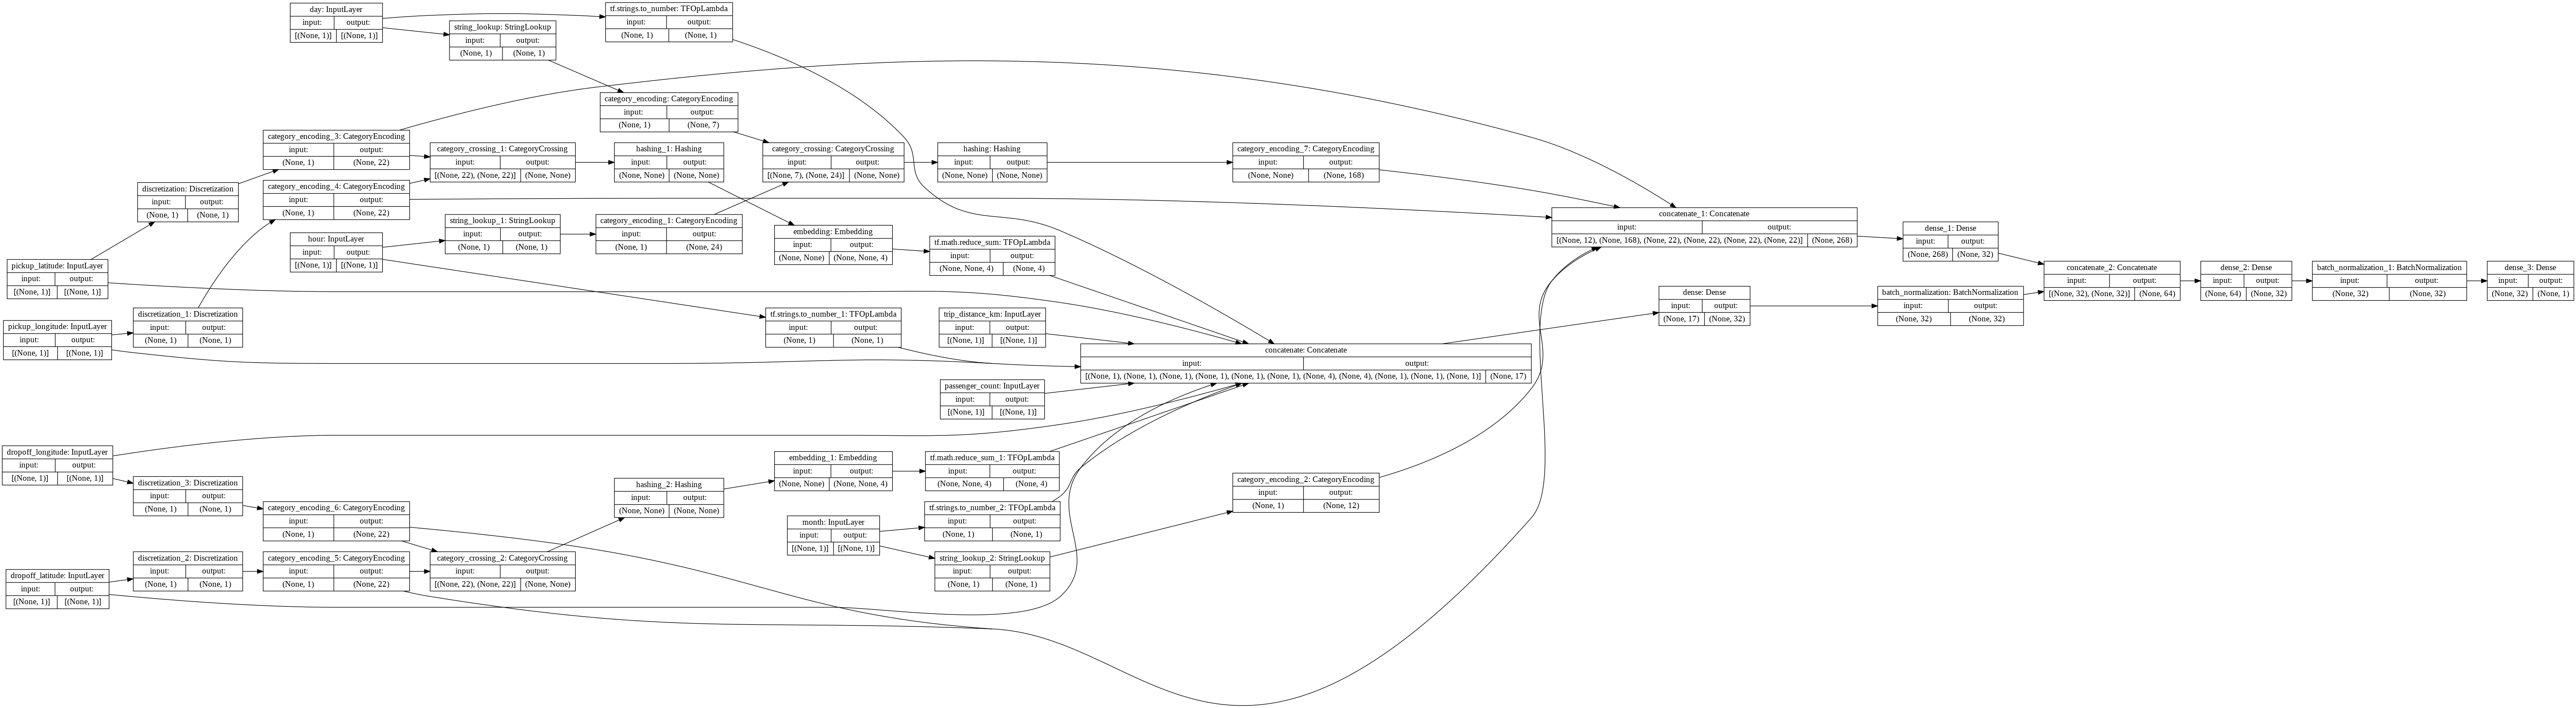

In [35]:
#Create dataset input functions
train_dataset = make_input_fn(filename = 'train*.csv',
                    mode = tf.estimator.ModeKeys.TRAIN,
                    # vnum_epochs = epochs,
                    batch_size = 128)()

validation_dataset = make_input_fn(filename = 'eval*.csv',
                    mode = tf.estimator.ModeKeys.EVAL,
                    # vnum_epochs = 1,
                    batch_size = 512)()

m_ = create_keras_model(params = params_default, feature_cols = create_feature_cols())
tf.keras.utils.plot_model(m_, show_shapes=True, rankdir="LR")

In [36]:
keras_train_and_evaluate(m_, train_dataset, validation_dataset, 20)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['pickup_datetime', 'split_date_time', 'date', 'time', 'split_date', 'split_time'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


100/100 [==============================] - 30s 269ms/step - loss: 188.3241 - rmse: 13.7221 - val_loss: 253.6842 - val_rmse: 15.9274
Epoch 2/20
100/100 [==============================] - 26s 257ms/step - loss: 152.1837 - rmse: 12.3353 - val_loss: 274.7253 - val_rmse: 16.5748
Epoch 3/20
100/100 [==============================] - 25s 256ms/step - loss: 122.9518 - rmse: 11.0806 - val_loss: 124.0661 - val_rmse: 11.1385
Epoch 4/20
100/100 [==============================] - 26s 257ms/step - loss: 79.5793 - rmse: 8.9196 - val_loss: 170.8661 - val_rmse: 13.0715
Epoch 5/20
100/100 [==============================] - 26s 257ms/step - loss: 68.9030 - rmse: 8.2983 - val_loss: 220.8461 - val_rmse: 14.8608
Epoch 6/20
100/100 [==============================] - 26s 257ms/step - loss: 58.5523 - rmse: 7.6474 - val_loss: 92.8689 - val_rmse: 9.6368
Epoch 7/20
100/100 [==============================] - 25s 256ms/step - loss: 56.2460 - rmse: 7.4946 - val_loss: 51.0367 - val_rmse: 7.1439
Epoch 8/20
100/100 [==

## Exporting Model

In [37]:
data = tf.data.Dataset.from_tensor_slices({'dropoff_latitude': [[23.920452]],
                         'dropoff_longitude': [[93.55]],
                         'pickup_latitude': [[23.5899]],
                         'pickup_longitude': [[92.466]],
                         'day': [["3"]],
                         'hour': [["8"]],
                         'month': [["4"]],
                         'trip_distance_km':[[0.003456]],
                         'passenger_count':[[3]]})

m_.predict(data)

array([[0.]], dtype=float32)

In [38]:
@tf.function
def serving(dropoff_latitude, dropoff_longitude, pickup_latitude, pickup_longitude, day, hour, month,passenger_count,trip_distance_km):
    ##Feature engineering( calculate distance )
    distance = tf.cast( tf.sqrt((tf.abs(dropoff_latitude - pickup_latitude))**2 + (tf.abs(dropoff_longitude - pickup_longitude))**2), tf.float32)

    payload = {
        'dropoff_latitude': dropoff_latitude,
        'dropoff_longitude': dropoff_longitude,
        'pickup_latitude': pickup_latitude,
        'pickup_longitude': pickup_longitude,
        'day': day,
        'hour': hour,
        'month': month,
        'trip_distance_km': trip_distance_km,
        'passenger_count':passenger_count

    }
    
    ## Predict
    ##IF THERE IS AN ERROR IN NUMBER OF PARAMS PASSED HERE OR DATA TYPE THEN IT GIVES ERROR, "COULDN'T COMPUTE OUTPUT TENSOR"
    predictions = m_(payload)
    return predictions

serving = serving.get_concrete_function(day=tf.TensorSpec([None,], dtype= tf.string, name='day'), 
                                        hour=tf.TensorSpec([None,], dtype= tf.string, name='hour'),
                                        month=tf.TensorSpec([None], dtype= tf.string, name='month'), 
                                        trip_distance_km=tf.TensorSpec([None], dtype= tf.float32, name='trip_distance_km'),
                                        passenger_count=tf.TensorSpec([None], dtype= tf.float32, name='passenger_count'),
                                        dropoff_latitude=tf.TensorSpec([None,], dtype= tf.float32, name='dropoff_latitude'),
                                        dropoff_longitude=tf.TensorSpec([None,], dtype= tf.float32, name='dropoff_longitude'), 
                                        pickup_latitude=tf.TensorSpec([None,], dtype= tf.float32, name='pickup_latitude'),
                                        pickup_longitude=tf.TensorSpec([None,], dtype= tf.float32, name='pickup_longitude')
                                        )

version = "1"  #{'serving_default': call_output}
tf.saved_model.save(
    m_,
    "./exported_model/" + version,
    signatures=serving
) 


INFO:tensorflow:Assets written to: ./exported_model/1/assets


In [39]:
!tar -cvf /content/model.tar /content/exported_model/1/

tar: Removing leading `/' from member names
/content/exported_model/1/
/content/exported_model/1/assets/
/content/exported_model/1/saved_model.pb
/content/exported_model/1/variables/
/content/exported_model/1/variables/variables.data-00000-of-00001
/content/exported_model/1/variables/variables.index


In [40]:
##Check signature
!saved_model_cli show --dir "./exported_model/1" --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['day'] tensor_info:
        dtype: DT_STRING
        shape: (-1)
        name: serving_default_day:0
    inputs['dropoff_latitude'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: serving_default_dropoff_latitude:0
    inputs['dropoff_longitude'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: serving_default_dropoff_longitude:0
    inputs['hour'] tensor_info:
        dtype: DT_STRING
        shape: (-1)
        name: serving_default_hour:

In [41]:
#LOCAL: Predict using Keras prediction function
saved_mod = tf.saved_model.load("./exported_model/" + version)

#Get prediction function from serving
f = saved_mod.signatures['serving_default']

#Run prediction function from serving
f(dropoff_latitude=tf.convert_to_tensor([41.920452]), dropoff_longitude = tf.convert_to_tensor([-87.679955]), pickup_latitude = tf.convert_to_tensor([41.952823]), 
  pickup_longitude =tf.convert_to_tensor([-87.653244]), day=tf.convert_to_tensor(["1"]), hour=tf.convert_to_tensor(["5"]),month=tf.convert_to_tensor(["6"]),trip_distance_km=tf.convert_to_tensor([0.5378]),
  passenger_count=tf.convert_to_tensor([2.0]))

{'output_0': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[26.782244]], dtype=float32)>}

In [42]:
###Install TF Model server

# This is the same as you would do from your command line, but without the [arch=amd64], and no sudo
# You would instead do:
# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

!apt-get remove tensorflow-model-server
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package tensorflow-model-server
deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  14788      0 --:--:-- --:--:-- --:--:-- 14715
OK
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 http://storage.googleapis.com/tensorflow

In [43]:
###Start Tensorflow server
# %%bash --bg 
# export TF_CPP_MIN_VLOG_LEVEL=0

%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8505 \
  --model_name=model \
  --model_base_path="/content/exported_model" >server.log 2>&1

Starting job # 0 in a separate thread.


In [44]:
import json
import requests

#Create payload
data_py = {"instances":[{'dropoff_latitude': [41.920452],
                         'dropoff_longitude': [-87.679955],
                         'pickup_latitude': [41.952823],
                         'pickup_longitude': [-87.653244],
                         'day': ["1"],
                         'hour': ["5"],
                         'month': ["6"]}]}

data = json.dumps(data_py)
print("payload: ", data)

#Run request on TMS
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8505/v1/models/model:predict', data=data, headers=headers)
json_response.text

payload:  {"instances": [{"dropoff_latitude": [41.920452], "dropoff_longitude": [-87.679955], "pickup_latitude": [41.952823], "pickup_longitude": [-87.653244], "day": ["1"], "hour": ["5"], "month": ["6"]}]}


ConnectionError: ignored